In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import sys
sys.path.insert(0, "../code-previous")

In [3]:
import pandas as pd
import numpy as np
import networkx as nx
import sklearn.feature_extraction as skfeatures

import time
import os

import seaborn as sns
sns.set_style('white')
import matplotlib.pylab as plt

import WOSutilities as wosutil

path2rawdata = '/mnt/disks/vault/wos2017-parsed/'

/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [4]:
# we need to load articles and categories

article_df = wosutil.load_wos_data(name = 'article', 
                                   path2rawdata = path2rawdata,
                                   year_list = None, 
                                   columns = ['ArticleID', 'PubYear', 'Doctypes', 'Title'], 
                                   dropna = ['ArticleID', 'PubYear'], 
                                   duplicate_subset = ['ArticleID'],
                                   isindict = {'Doctypes':np.sort(['Article','Letter','Review','Note'])}, 
                                   verbose = 50)

# select all categories for all the aricles published
category_list = np.array(['Physics, Applied'])  

category_df = wosutil.load_wos_data(name = 'category', 
                                    path2rawdata = path2rawdata,
                                    year_list = None,
                                    columns = None, 
                                    dropna = ['ArticleID'], 
                                    duplicate_subset = None,
                                    isindict = {'Label':category_list},
                                    verbose = 100)

50
100
150
200
250
300
350
400
450
Final DF Shape (39171592, 4)
100
200
300
400
Final DF Shape (1289055, 3)


In [5]:
# Article data frame
article_df.head()

,ArticleID,PubYear,Doctypes,Title
84871,A1981LC59600003,1981,Article,SPORADIC LEGIONELLOSIS IN THE UNITED-STATES - ...
37725,A1981LC51800016,1981,Article,REACTION OF LEAD PERCHLORATE WITH AMMONIUM HYD...
37729,A1981MP52000011,1981,Article,ELECTRICAL PACING FOR SHORT BOWEL SYNDROME
37730,A1981LZ55900001,1981,Review,STABILITY TESTING OF SOLID DRUGS USING PREFERE...
37732,A1981ME20500010,1981,Article,ON THE DETERMINATION OF THE 1ST NORMAL STRESS ...


In [6]:
# category data frame
category_df.head()

,ArticleID,Type,Label
482633,A1981LJ96300019,ASCA traditional subject,"Physics, Applied"
178150,A1981MM58300017,ASCA traditional subject,"Physics, Applied"
178373,A1981LV54600009,ASCA traditional subject,"Physics, Applied"
178624,A1981LX06200023,ASCA traditional subject,"Physics, Applied"
179210,A1981LG93900006,ASCA traditional subject,"Physics, Applied"


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f1cf05f5940>]],
      dtype=object)

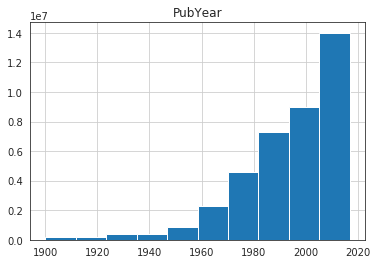

In [7]:
#plot of articles each year - sample

article_df.hist(column='PubYear')

In [8]:
# joining the dataframes
data = article_df.merge(category_df, 
                        how = 'left',
                        on = 'ArticleID')

In [9]:
# there are no duplicates
data = data.dropna()
data = data.sort_values(by="PubYear")
data['Label'].unique()

array(['Physics, Applied'], dtype=object)

In [10]:
# tiny processing - removing stop words from title
import preprocessing as pp

data['article_tokens'] = data.Title.apply(lambda x: pp.process(x))
data.head()

,ArticleID,PubYear,Doctypes,Title,Type,Label,article_tokens
28887094,000202851500011,1900,Article,On the geology and fossil corals and Echinids ...,ASCA traditional subject,"Physics, Applied","[geology, fossil, coral, echinids, somaliland]"
29327791,000208074300002,1900,Article,The Molecular Constitution of Water.,ASCA traditional subject,"Physics, Applied","[molecular, constitution, water]"
29323469,000208074300006,1900,Article,The Motion of a Sphere in a Viscous Fluid.,ASCA traditional subject,"Physics, Applied","[motion, sphere, viscous, fluid]"
28903419,000208074900006,1900,Article,"The Rates of a Rocking Watch, with Remarks on ...",ASCA traditional subject,"Physics, Applied","[rate, rocking, watch, remark, gravitational, ..."
29525539,000208073700007,1900,Article,The Chemical and Geological History of the Atm...,ASCA traditional subject,"Physics, Applied","[chemical, geological, history, atmosphere]"


In [11]:
keywords = data['article_tokens'].tolist()
flat_list = [item for sublist in keywords for item in sublist]

from collections import Counter
frequencies = dict(Counter(flat_list))

import operator
keywords_sorted_by_freq = sorted(frequencies.items(), key=operator.itemgetter(1), reverse=True)
frequent_words = [word for (word, freq) in keywords_sorted_by_freq]

# top 20 keywords in titles in the corpus
frequent_words[:20]

['film',
 'effect',
 'property',
 'laser',
 'using',
 'study',
 'surface',
 'optical',
 'thin',
 'structure',
 'silicon',
 'magnetic',
 'crystal',
 'temperature',
 'growth',
 'system',
 'plasma',
 'measurement',
 'layer',
 'method']

In [12]:
data['PubYear'].unique()

array([1900, 1901, 1902, 1903, 1904, 1905, 1906, 1907, 1908, 1909, 1910,
       1911, 1912, 1913, 1914, 1915, 1916, 1917, 1918, 1919, 1920, 1921,
       1922, 1923, 1924, 1925, 1926, 1927, 1928, 1929, 1930, 1931, 1932,
       1933, 1934, 1935, 1936, 1937, 1938, 1939, 1940, 1941, 1942, 1943,
       1944, 1945, 1946, 1947, 1948, 1949, 1950, 1951, 1952, 1953, 1954,
       1955, 1956, 1957, 1958, 1959, 1960, 1961, 1962, 1963, 1964, 1965,
       1966, 1967, 1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976,
       1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987,
       1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998,
       1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009,
       2010, 2011, 2012, 2013, 2014, 2015, 2016])

In [13]:
from wordcloud import WordCloud

# wordcloud = WordCloud(background_color='white')
# wordcloud.generate_from_frequencies(frequencies=frequencies)
# plt.figure()
# plt.imshow(wordcloud, interpolation="bilinear")
# plt.axis("off")
# plt.show()

In [14]:
#binning ranges

bins = [(1899 + x) for x in range(0,100,10)]
data['pub_year_binned'] = pd.cut(data['PubYear'], bins)
data[data['PubYear'] == 1906].head()

,ArticleID,PubYear,Doctypes,Title,Type,Label,article_tokens,pub_year_binned
29125810,000202852700027,1906,Article,On a non-leaking glass tap,ASCA traditional subject,"Physics, Applied","[nonleaking, glass]","(1899, 1909]"
28938304,000202852700001,1906,Article,Deep sea ship-waves.,ASCA traditional subject,"Physics, Applied","[deep, shipwaves]","(1899, 1909]"
29445976,000202852800010,1906,Article,Interference colours of chlorate of potash cry...,ASCA traditional subject,"Physics, Applied","[interference, colour, chlorate, potash, cryst...","(1899, 1909]"
28751147,000202852700062,1906,Article,LXX. On the number of corpuscles in an atom,ASCA traditional subject,"Physics, Applied","[number, corpuscle, atom]","(1899, 1909]"
29208059,000202852700060,1906,Article,LXVIII. The black spot in the thin liquid films,ASCA traditional subject,"Physics, Applied","[lxviii, black, spot, thin, liquid, film]","(1899, 1909]"


In [15]:
del data['Doctypes']
del data['Type']
del data['Label']
del data['Title']
del data['ArticleID']

In [16]:
year_ranges = data['pub_year_binned'].unique()
foo = [data[data['pub_year_binned'] == year_range] for year_range in year_ranges]

In [17]:
# removing 'data' from memory - not sure if this works
import gc
del [[data]]
gc.collect()
data=pd.DataFrame()

[(1899, 1909]]
Categories (1, interval[int64]): [(1899, 1909]]


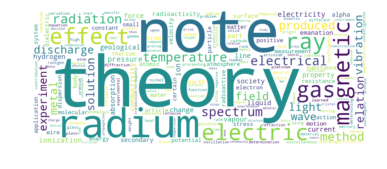

[(1909, 1919]]
Categories (1, interval[int64]): [(1909, 1919]]


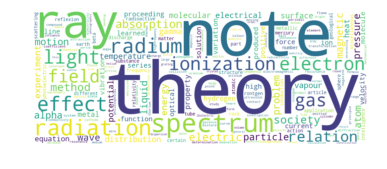

[(1919, 1929]]
Categories (1, interval[int64]): [(1919, 1929]]


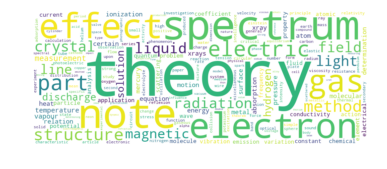

[(1929, 1939]]
Categories (1, interval[int64]): [(1929, 1939]]


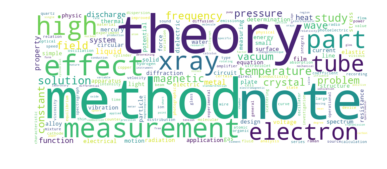

[(1939, 1949]]
Categories (1, interval[int64]): [(1939, 1949]]


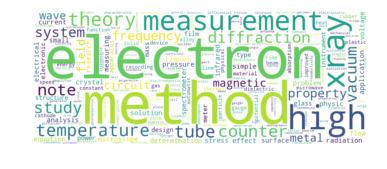

[(1949, 1959]]
Categories (1, interval[int64]): [(1949, 1959]]


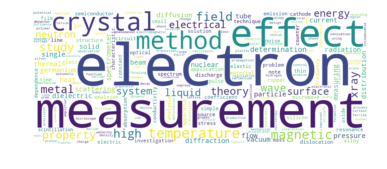

[(1959, 1969]]
Categories (1, interval[int64]): [(1959, 1969]]


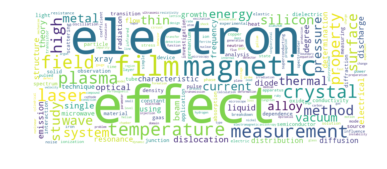

[(1969, 1979]]
Categories (1, interval[int64]): [(1969, 1979]]


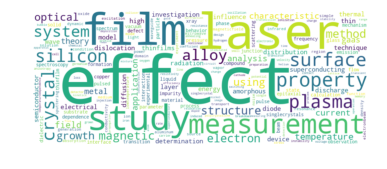

[(1979, 1989]]
Categories (1, interval[int64]): [(1979, 1989]]


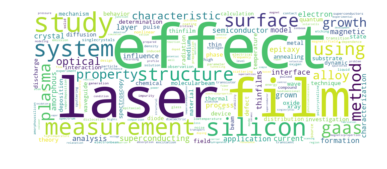

[], Categories (0, interval[int64]): []


ValueError: We need at least 1 word to plot a word cloud, got 0.

In [18]:
for period in range(len(foo)):
    
    keywords = foo[period]['article_tokens'].tolist()
    flat_list = [item for sublist in keywords for item in sublist]

    from collections import Counter
    frequencies = dict(Counter(flat_list))
    
    print(foo[period]['pub_year_binned'].unique())
    
    wordcloud = WordCloud(background_color='white',
                          width=1000, 
                          height=400)
    wordcloud.generate_from_frequencies(frequencies=frequencies)
    plt.figure()
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()
    